In [0]:
import json
import matplotlib.pyplot as plt
import pandas as pd

# Weather Data

In [16]:
!wget https://datacases.s3.us-east-2.amazonaws.com/datathon-2020/Ernst+and+Young/Dubai+Weather_20180101_20200316.txt

--2020-05-16 00:51:13--  http://data.bayanat.ae/ar/dataset/ad38cee7-f70e-4764-9c9d-aab760ce1026/resource/025ea6b2-a806-49c2-8294-4f3a97c09090/download/traffic_incidents-1.csv
Resolving data.bayanat.ae (data.bayanat.ae)... 185.141.13.100
Connecting to data.bayanat.ae (data.bayanat.ae)|185.141.13.100|:80... connected.
HTTP request sent, awaiting response... 302 Found : Moved Temporarily
Location: https://data.bayanat.ae/ar/dataset/ad38cee7-f70e-4764-9c9d-aab760ce1026/resource/025ea6b2-a806-49c2-8294-4f3a97c09090/download/traffic_incidents-1.csv [following]
--2020-05-16 00:51:14--  https://data.bayanat.ae/ar/dataset/ad38cee7-f70e-4764-9c9d-aab760ce1026/resource/025ea6b2-a806-49c2-8294-4f3a97c09090/download/traffic_incidents-1.csv
Connecting to data.bayanat.ae (data.bayanat.ae)|185.141.13.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2716239 (2.6M) [text/csv]
Saving to: ‘traffic_incidents-1.csv’

traffic_incidents-1 100%[===================>]   2.59M   181KB

In [4]:
df = pd.read_json("Dubai+Weather_20180101_20200316.txt")
df.dtypes

city_name     object
lat          float64
lon          float64
main          object
wind          object
clouds        object
weather       object
dt             int64
dt_iso        object
timezone       int64
rain          object
dtype: object

### Flat json data type

In [0]:
s = df.apply(lambda x: pd.Series(x['weather']),axis=1).stack().reset_index(level=1, drop=True) # Weather column is a list which only contains one object
s.name = 'weather'
df = df.drop('weather', axis=1).join(s)
json_struct = json.loads(df.to_json(orient="records"))    
df_flat = pd.json_normalize(json_struct)

### Remove columns which only contain one same element

In [6]:
for col in df_flat.columns: # remove useless columns
  unique = df_flat[col].unique()
  if unique.size == 1:
    df_flat.drop(col, axis=1, inplace=True)
    print(f'drop {col}')
  else:
    print(f'{col} {unique.shape}: {unique[:5]}')

drop city_name
drop lat
drop lon
dt (19344,): [1514764800 1514768400 1514772000 1514775600 1514779200]
dt_iso (19344,): ['2018-01-01 00:00:00 +0000 UTC' '2018-01-01 01:00:00 +0000 UTC'
 '2018-01-01 02:00:00 +0000 UTC' '2018-01-01 03:00:00 +0000 UTC'
 '2018-01-01 04:00:00 +0000 UTC']
drop timezone
drop rain
main.temp (3075,): [14.99 14.63 14.03 13.78 14.28]
main.temp_min (2416,): [13.   12.   16.   19.31 20.61]
main.temp_max (2444,): [18. 17. 19. 21. 23.]
main.feels_like (3331,): [13.7  13.91 13.89 13.14 13.45]
main.pressure (46,): [1015 1016 1017 1014 1013]
main.humidity (87,): [87 93 68 64 56]
wind.speed (142,): [3.1 2.6 1.5 2.1 0.5]
wind.deg (112,): [150 180 160   0 340]
clouds.all (101,): [ 1  0 20 75 40]
weather.id (17,): [800 701 721 801 803]
weather.main (9,): ['Clear' 'Mist' 'Haze' 'Clouds' 'Rain']
weather.description (17,): ['sky is clear' 'mist' 'haze' 'few clouds' 'broken clouds']
weather.icon (16,): ['01n' '50n' '50d' '01d' '02n']
rain.1h (23,): [ nan 0.14 2.03 0.11 0.35]
ra

### Since weather id matchs weather description, and it has more category than weather main, we can just keep id and remove main, icon, and description

In [0]:
df_flat.drop(['weather.main', 'weather.icon', 'weather.description'], axis=1, inplace=True)

### Check NaN and only rain contains that. Fill it with 0

In [8]:
df=df_flat
print(df.isnull().sum())
df.fillna(0, inplace=True)

dt                     0
dt_iso                 0
main.temp              0
main.temp_min          0
main.temp_max          0
main.feels_like        0
main.pressure          0
main.humidity          0
wind.speed             0
wind.deg               0
clouds.all             0
weather.id             0
rain.1h            19319
rain.3h            19262
dtype: int64


In [9]:
df.describe()

,dt,main.temp,main.temp_min,main.temp_max,main.feels_like,main.pressure,main.humidity,wind.speed,wind.deg,clouds.all,weather.id,rain.1h,rain.3h
count,1.934700e+04,19347.000000,19347.000000,19347.000000,19347.000000,19347.000000,19347.000000,19347.000000,19347.000000,19347.000000,19347.000000,19347.000000,19347.000000
mean,1.549584e+09,28.103518,26.662334,29.811445,27.685407,1009.415465,52.495891,3.879835,188.369153,13.758050,791.030806,0.000601,0.003641
std,2.010261e+07,7.329281,7.579672,7.241003,8.309739,8.016809,21.659532,2.099726,106.259695,26.485413,41.399420,0.023247,0.068180
min,1.514765e+09,10.890000,7.000000,12.000000,6.340000,972.000000,4.000000,0.300000,0.000000,0.000000,200.000000,0.000000,0.000000
25%,1.532176e+09,22.030000,20.925000,23.845000,20.750000,1003.000000,35.000000,2.340000,100.000000,0.000000,800.000000,0.000000,0.000000
50%,1.549588e+09,28.060000,26.670000,30.000000,27.320000,1011.000000,53.000000,3.600000,180.000000,1.000000,800.000000,0.000000,0.000000
75%,1.566992e+09,33.880000,32.810000,35.130000,34.890000,1016.000000,69.000000,5.100000,290.000000,19.000000,800.000000,0.000000,0.000000
max,1.584400e+09,45.940000,45.360000,48.000000,47.890000,1026.000000,100.000000,14.900000,360.000000,100.000000,804.000000,2.030000,3.810000


### Normalize and visualize data based on time

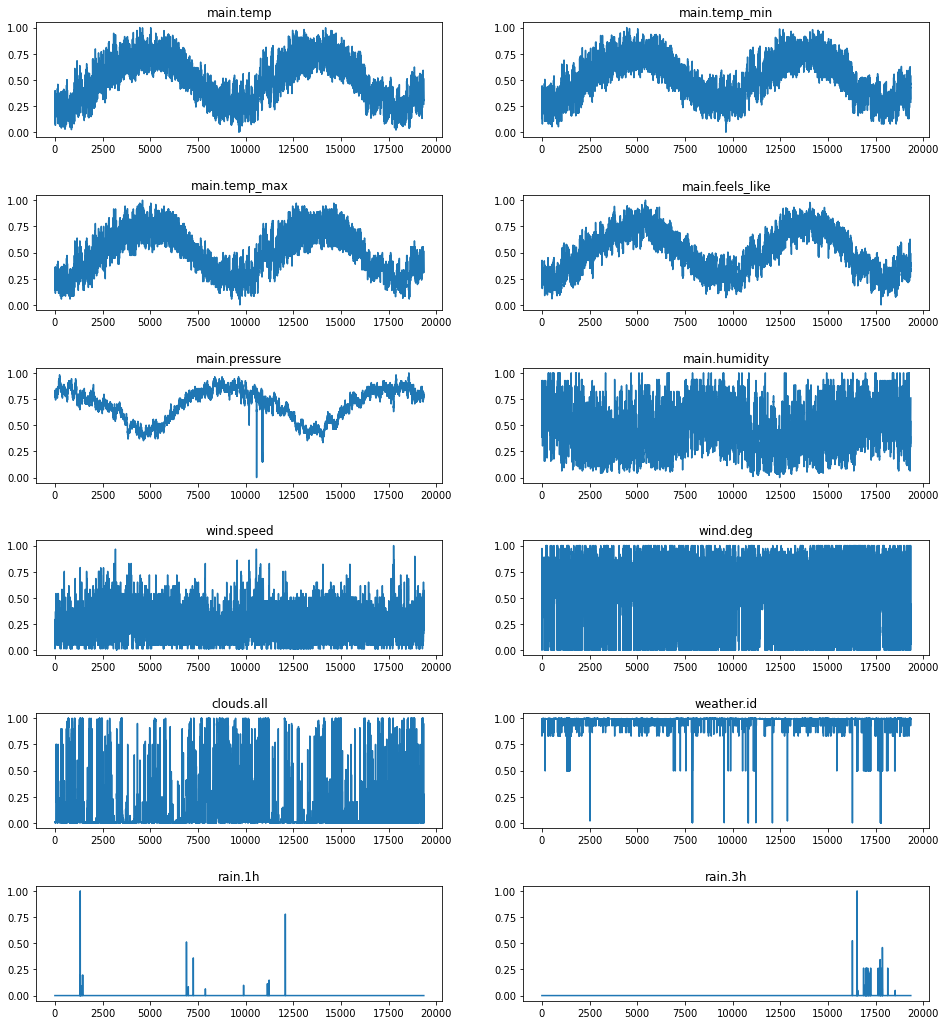

In [12]:
df.sort_values(by=['dt'], inplace=True)
dfwithouttime = df.drop(['dt','dt_iso'], axis=1)
dfwithouttime=(dfwithouttime-dfwithouttime.min())/(dfwithouttime.max()-dfwithouttime.min()) #normalize
fig, axs = plt.subplots(6, 2, figsize=(16, 18))
fig.subplots_adjust(hspace=.5)
i = 0
j = 0
for col in dfwithouttime.columns:
    dfwithouttime[col].plot(ax=axs[i][j], title=col)
    j += 1
    if j == 2:
      j = 0
      i += 1

In [40]:
print(df.dt_iso, df.dtypes)
df.dt_iso = pd.to_datetime(df.dt_iso, format='%Y-%m-%d %H:%M:%S +0000 UTC')
print(df.dt_iso, df.dtypes)

0        2018-01-01 00:00:00 +0000 UTC
1        2018-01-01 01:00:00 +0000 UTC
2        2018-01-01 02:00:00 +0000 UTC
3        2018-01-01 03:00:00 +0000 UTC
4        2018-01-01 04:00:00 +0000 UTC
                     ...              
19342    2020-03-16 19:00:00 +0000 UTC
19343    2020-03-16 20:00:00 +0000 UTC
19344    2020-03-16 21:00:00 +0000 UTC
19345    2020-03-16 22:00:00 +0000 UTC
19346    2020-03-16 23:00:00 +0000 UTC
Name: dt_iso, Length: 19347, dtype: object dt                   int64
dt_iso              object
main.temp          float64
main.temp_min      float64
main.temp_max      float64
main.feels_like    float64
main.pressure        int64
main.humidity        int64
wind.speed         float64
wind.deg             int64
clouds.all           int64
weather.id           int64
rain.1h            float64
rain.3h            float64
dtype: object
0       2018-01-01 00:00:00
1       2018-01-01 01:00:00
2       2018-01-01 02:00:00
3       2018-01-01 03:00:00
4       2018-01-01 04:00

# Traffic data

In [0]:
!wget http://data.bayanat.ae/ar/dataset/ad38cee7-f70e-4764-9c9d-aab760ce1026/resource/025ea6b2-a806-49c2-8294-4f3a97c09090/download/traffic_incidents-1.csv
!wget https://www.dubaipulse.gov.ae/dataset/c9263194-5ee3-4340-b7c0-3269b26acb43/resource/c3ece154-3071-4116-8650-e769d8416d88/download/traffic_incidents.csv

In [33]:
df1 = pd.read_csv("traffic_incidents.csv")
df2 = pd.read_csv("traffic_incidents-1.csv")
print(df1.dtypes, df2.dtypes)
print(df1.shape[0] + df2.shape[0])
df_union= pd.concat([df1, df2]).drop_duplicates()
print(df_union.shape)

acci_id        int64
acci_time     object
acci_name     object
acci_x       float64
acci_y       float64
dtype: object acci_id        int64
acci_time     object
acci_name     object
acci_x       float64
acci_y       float64
dtype: object
79566
(65634, 5)


### We only need time

In [34]:
df_union = df_union[['acci_time']]
print(df_union.shape, df_union.acci_time.unique().shape)
df_union.tail

(65634, 1) (64567,)


<bound method NDFrame.tail of                  acci_time
0      15/05/2020 18:25:10
1      15/05/2020 19:56:38
2      15/05/2020 20:00:27
3      15/05/2020 20:00:37
4      15/05/2020 20:02:39
...                    ...
23816  27/06/2019 11:21:09
23817  27/06/2019 11:21:35
23818  27/06/2019 11:24:07
23819  27/06/2019 11:24:27
23820  27/06/2019 11:25:26

[65634 rows x 1 columns]>

In [0]:
df_union.acci_time = pd.to_datetime(df_union.acci_time, format='%d/%m/%Y %H:%M:%S')
df_union.sort_values(by=['acci_time'], inplace=True)

### Group by hour

,acci_time,count
0,2019-06-27 10:00:00,4
1,2019-06-27 11:00:00,19
2,2019-06-27 12:00:00,21
3,2019-06-27 13:00:00,26
4,2019-06-27 14:00:00,0
...,...,...
7758,2020-05-15 16:00:00,4
7759,2020-05-15 17:00:00,3
7760,2020-05-15 18:00:00,4
7761,2020-05-15 19:00:00,1


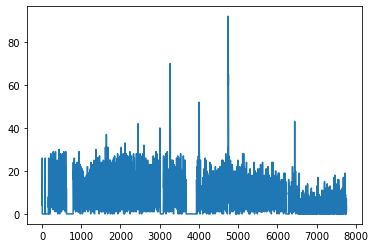

In [46]:
dfh = df_union.groupby([pd.Grouper(key='acci_time',freq='H')]).size().reset_index(name='count')
dfh['count'].plot()
dfh

## Inner Join weather and traffic accident data

In [0]:
result = pd.merge(df, dfh, how='inner', left_on=['dt_iso'], right_on=['acci_time'])
result.drop(['acci_time', 'dt'], axis=1, inplace=True)

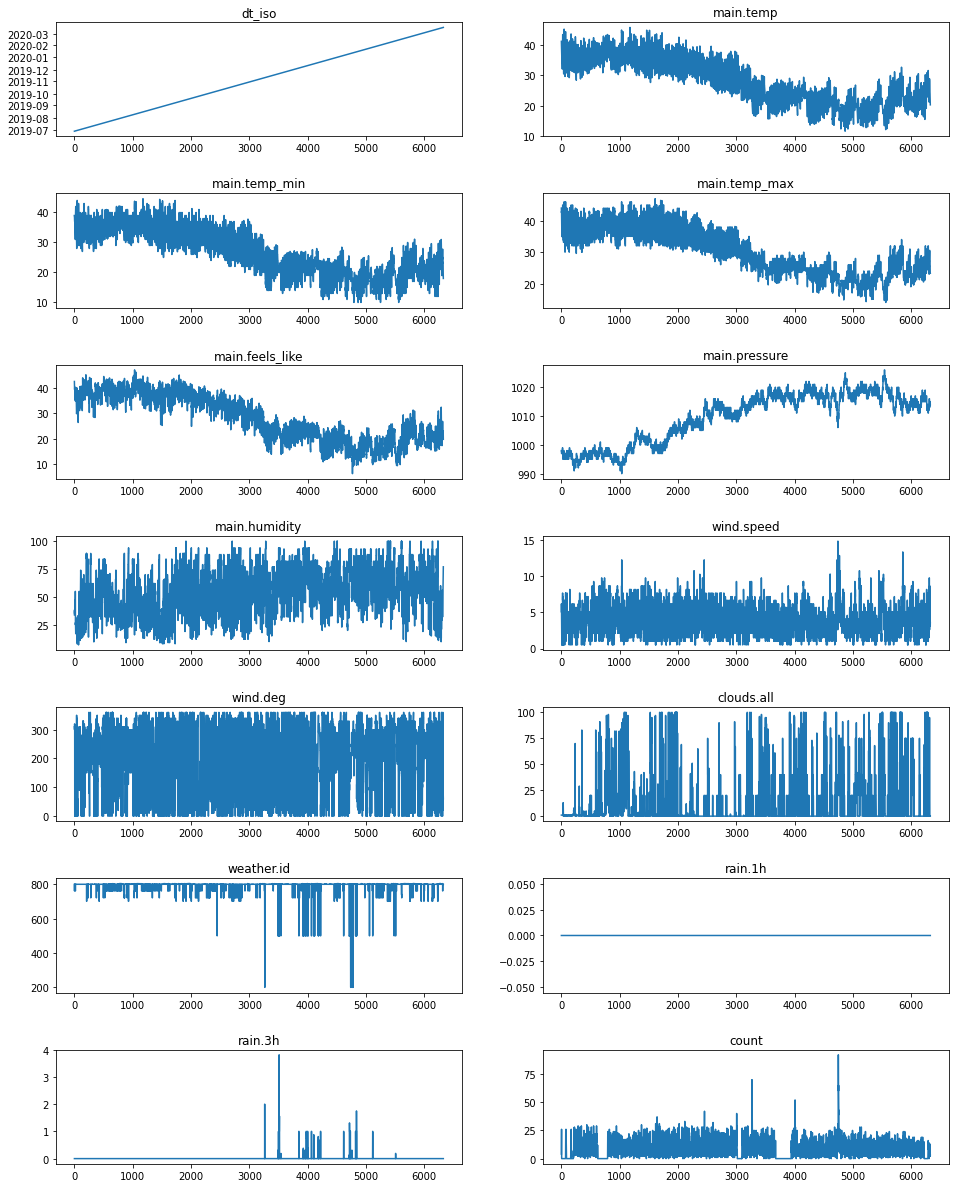

In [47]:
fig, axs = plt.subplots(7, 2, figsize=(16, 21))
fig.subplots_adjust(hspace=.5)
i = 0
j = 0
for col in result.columns:
    result[col].plot(ax=axs[i][j], title=col)
    j += 1
    if j == 2:
      j = 0
      i += 1

In [0]:
result.drop('rain.1h', axis=1, inplace=True)